<a href="https://colab.research.google.com/github/ContiPaolo/MultiFidelity_NNs/blob/main/Tutorial_2_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity regression with neural networks**

In [1]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import STATUS_OK, tpe, Trials, hp, fmin
from hyperopt.pyll.base import scope
from sklearn.model_selection import KFold
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import extmath

# Set random seed for reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

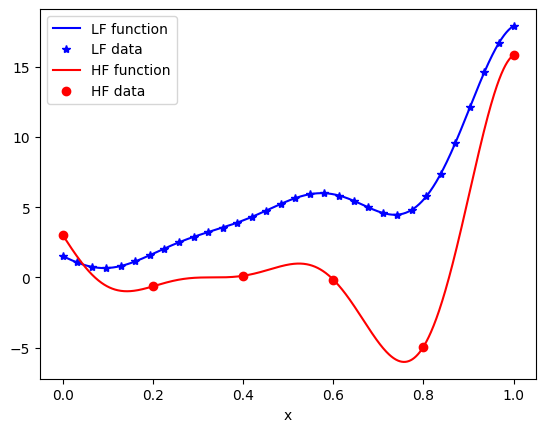

In [2]:
## Define benchmark functions

# Linear correlation benchmark
highfid = lambda x: (6.*x-2.)**2*np.sin(12.*x-4.)
lowfid  = lambda x: 0.5*highfid(x) + 10*(x-0.5) + 5.

# Discontinuous and nonlinear correlation benchmark
#lowfid = lambda x: (0.5*(6.*x-2.)**2*np.sin(12.*x-4)+10.*(x-0.5)-5.)*(x<0.5) + (3+0.5*(6.*x-2)**2*np.sin(12.*x-4)+10*(x-0.5)-5.)*(x>0.5)
#highfid = lambda x: (2*lowfid(x)- 20*x+20)*(x<0.5) + (4+2*lowfid(x)- 20*x+20)*(x>0.5)

## Generate data
Nhf = 6   # Number of HF points
Nlf = 32  # Number of LF points
xhf = np.linspace(0, 1, Nhf)
xlf = np.linspace(0, 1, Nlf)

## Normalize data
x_big = np.linspace(0, 1, 1000000)
hfmean = np.mean(highfid(x_big))
lfmean = np.mean(lowfid(x_big))

Yhf = highfid(xhf) - hfmean
Ylf = lowfid(xlf) - lfmean

## Test data
x_test = np.linspace(0, 1, 1000)
Yhf_test = highfid(x_test) - hfmean

## Plot functions
plt.figure()
plt.plot(x_test, lowfid(x_test), 'b-', label = 'LF function')
plt.plot(xlf, lowfid(xlf), 'b*', label = 'LF data')
plt.plot(x_test, highfid(x_test), 'r-', label = 'HF function')
plt.plot(xhf, highfid(xhf), 'ro', label = 'HF data')
plt.xlabel('x')
plt.legend()
plt.show()

# **Single-Fidelity: Low-fidelity model**
Create a neural network surrogate model which maps `xlf` inputs to `Ylf` outputs.

The network should have:
- 3 hidden Dense layers
- 64 nodes per layer
- activation function = 'tanh'
- kernel_initializer = 'glorot_uniform'
- kernel_regularizer = l2($\lambda$) with $\lambda = 10^{-4}$


In [3]:
# Define the LF model and compile it
inputs = Input(shape=(1,))
x = Dense(64, activation='tanh', kernel_regularizer=l2(1e-4), kernel_initializer='glorot_uniform')(inputs)
x = Dense(64, activation='tanh', kernel_regularizer=l2(1e-4), kernel_initializer='glorot_uniform')(x)
x = Dense(64, activation='tanh', kernel_regularizer=l2(1e-4), kernel_initializer='glorot_uniform')(x)
output = Dense(1, activation='linear', name='LF')(x)

modelLF = Model(inputs, output)
optimizer = Adam(learning_rate=0.0255)
modelLF.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


# Train the LF model
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism() # for reproducibility
histLF = modelLF.fit(xlf, Ylf, epochs=500, batch_size=Nlf, verbose=1)


# Evaluate the LF model on the test set
yLF = modelLF.predict(x_test)[:, 0]

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 18.7422 - mse: 18.7294
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 17.6628 - mse: 17.6494
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 16.5056 - mse: 16.4920
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 11.6119 - mse: 11.5980
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 6.9660 - mse: 6.9515
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 6.4226 - mse: 6.4074
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8.8464 - mse: 8.8306
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8.3664 - mse: 8.3502
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 7.1463 - mse: 7.1300
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 6.4567 - mse: 6.4403
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 6.8665 - mse: 6.8500
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.6771 - mse: 7.6604
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Plot the exact HF solution, the predicted LF solution and the LF training data

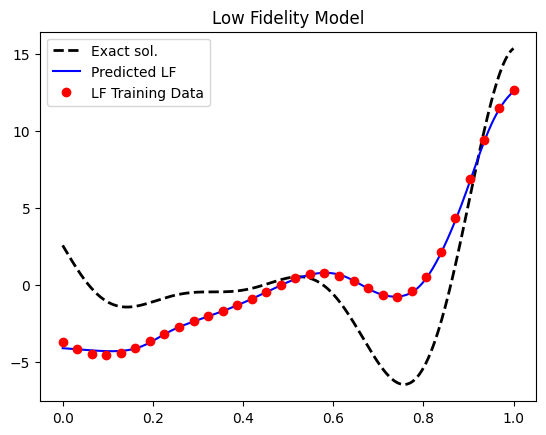

In [4]:
# Plot LF results
plt.figure()
plt.plot(x_test, Yhf_test, 'k--', label = 'Exact sol.', linewidth = 2)
plt.plot(x_test, yLF, 'b-', label='Predicted LF')
plt.plot(xlf, Ylf, 'ro', label='LF Training Data')
plt.legend()
plt.title('Low Fidelity Model')
plt.show()

# **Single-Fidelity: High-fidelity model**
Create a neural network surrogate model which maps `xhf` inputs to `Yhf` outputs.

The network should have:
- 1 hidden Dense layers
- 32 nodes per layer
- activation function = 'tanh'
- kernel_initializer = 'glorot_uniform'
- kernel_regularizer = l2($\lambda$) with $\lambda = 10^{-4}$


In [5]:
# Define the HF model and compile it
inputs = Input(shape=(1,))
x = Dense(32, activation='tanh', kernel_regularizer=l2(1e-4), kernel_initializer='glorot_uniform')(inputs)
output = Dense(1, activation='linear', name='HF')(x)

modelHF = Model(inputs, output)
optimizer = Adam(learning_rate=0.0255)
modelHF.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


# Train the HF model
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism() # for reproducibility
histHF = modelHF.fit(xhf, Yhf, epochs=500, batch_size=Nhf, verbose=1)


# Evaluate the HF model on the test set
yHF = modelHF.predict(x_test)[:, 0]

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 46.1172 - mse: 46.1170
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 44.4487 - mse: 44.4485
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 43.0887 - mse: 43.0885
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 42.0132 - mse: 42.0130
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 41.2085 - mse: 41.2083
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 40.6678 - mse: 40.6675
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 40.3700 - mse: 40.3697
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 40.2545 - mse: 40.2542
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 40.2213 - mse: 40.2210
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 40.1740 - mse: 40.1737
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 40.0550 - mse: 40.0546
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 39.8510 - mse: 39.8507
Epoch 13/500
1/1 ━━━━━━━━━━

Plot the exact HF solution, the predicted HF solution and the HF training data

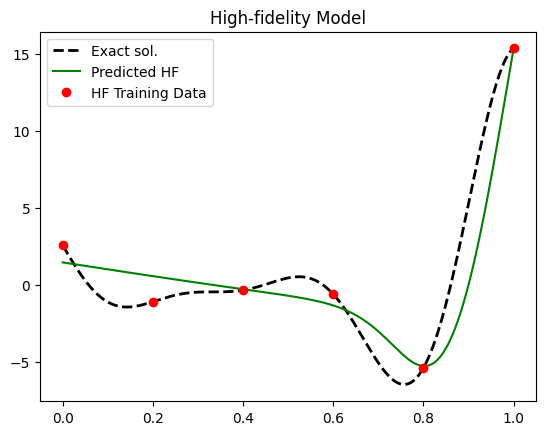

In [6]:
# Plot HF results
plt.figure()
plt.plot(x_test, Yhf_test, 'k--', label = 'Exact sol.', linewidth = 2)
plt.plot(x_test, yHF, 'g-', label='Predicted HF')
plt.plot(xhf, Yhf, 'ro', label='HF Training Data')
plt.legend()
plt.title('High-fidelity Model')
plt.show()

# **Multi-fidelity model: 2-step network**
Create a neural network surrogate model which maps the `xhf` inputs AND the LF predictions in correspondence of the HF inputs, i.e. `modelLF(xhf)`, to the `Yhf` outputs.


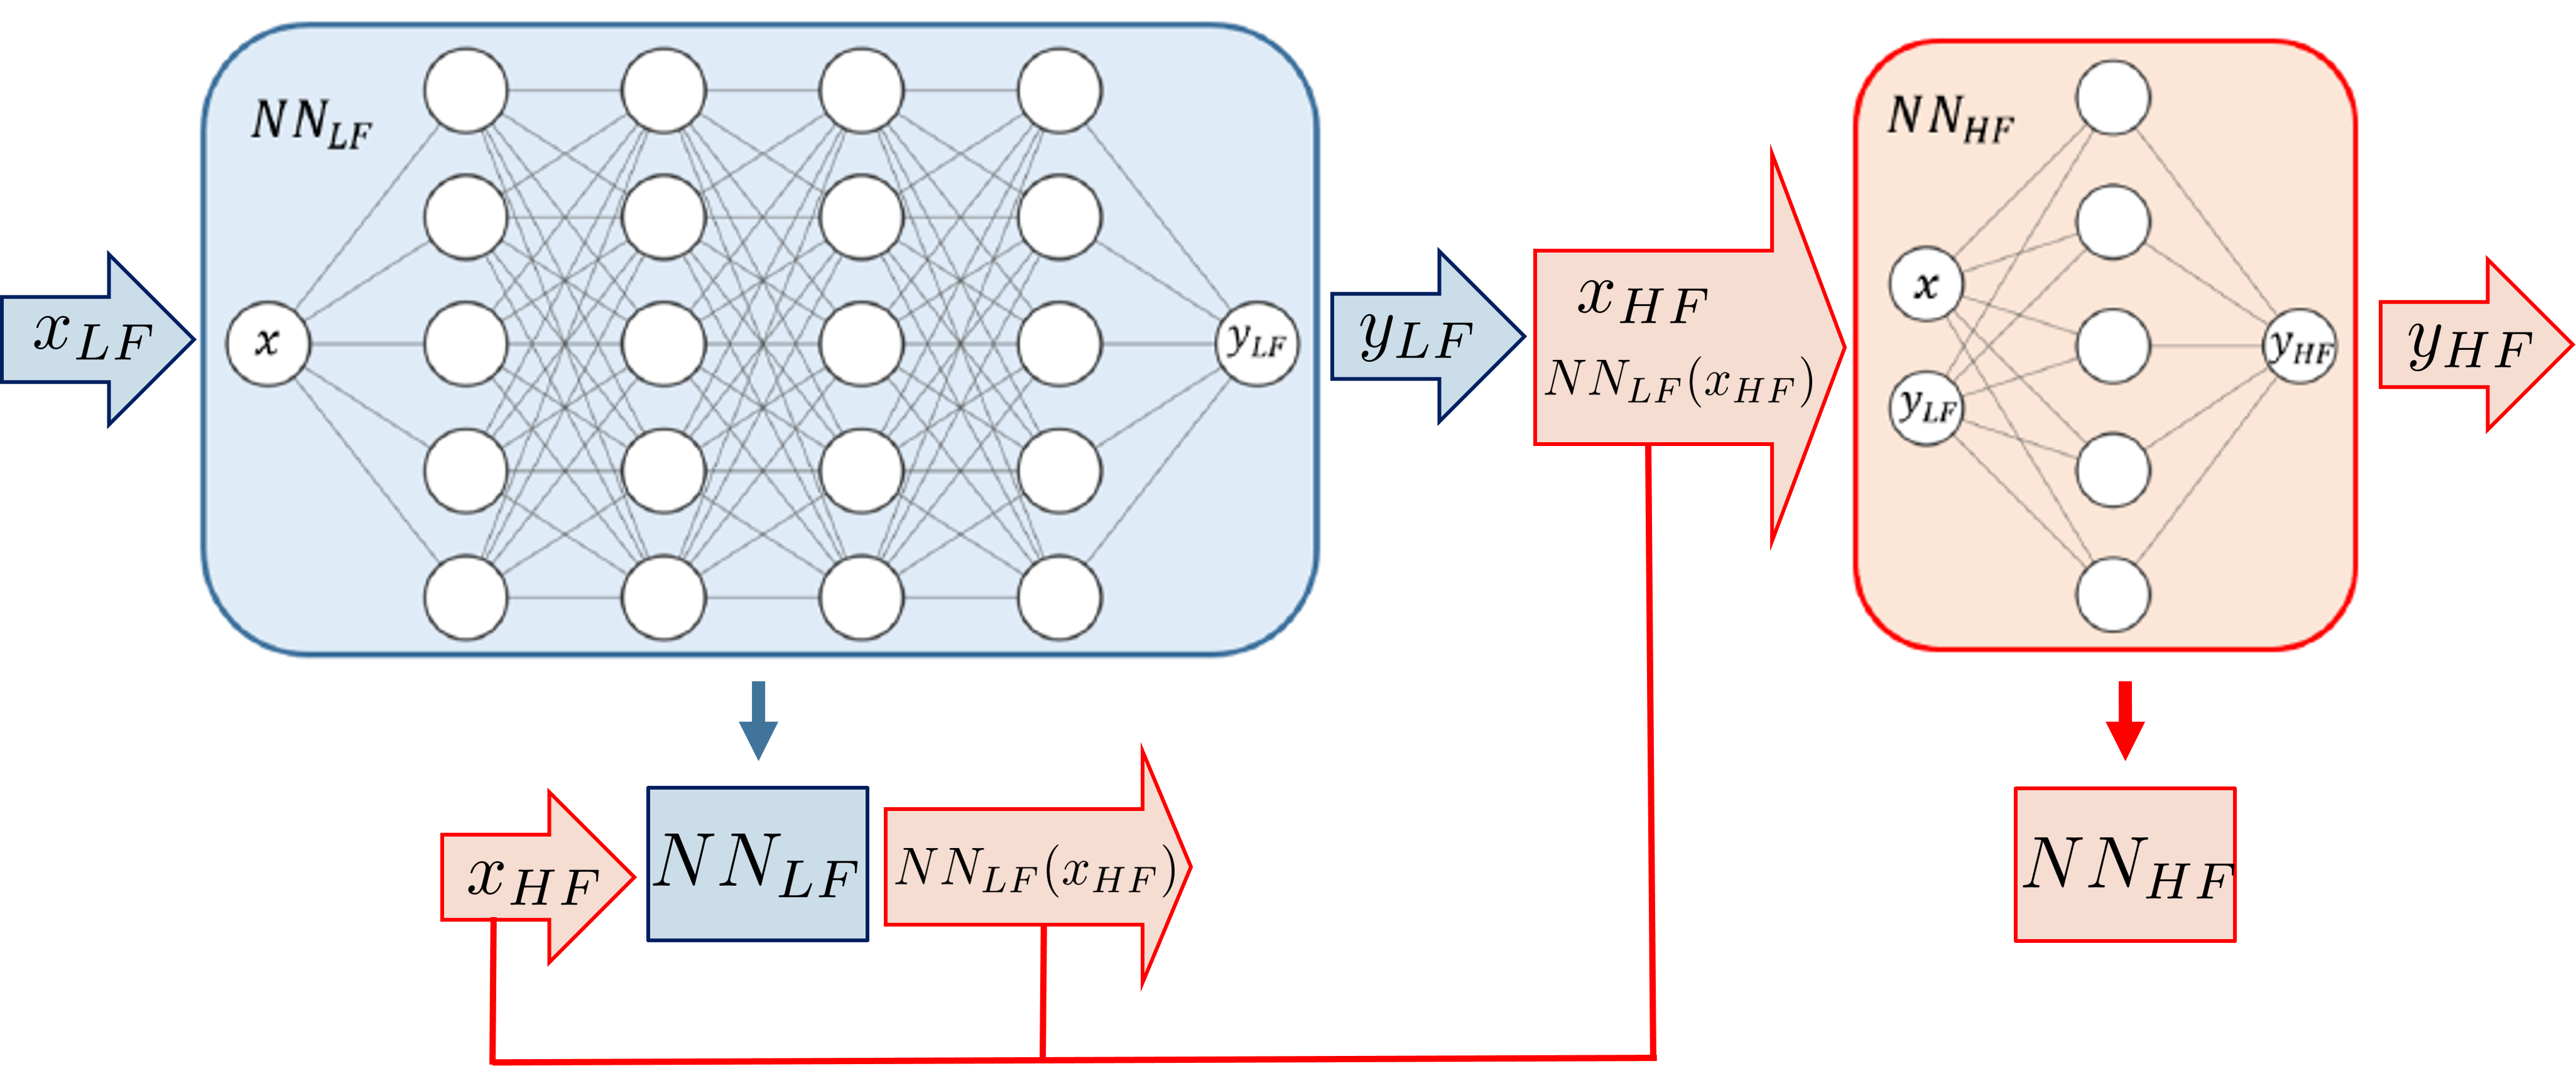

The new network should have:
- 1 hidden Dense layers
- 32 nodes per layer
- activation function = 'tanh'
- kernel_initializer = 'glorot_uniform'
- kernel_regularizer = l2($\lambda$) with $\lambda = 10^{-4}$


In [7]:
# Evalute the LF model at the HF inputs
xhf_help = modelLF.predict(xhf)[:, 0]

# Create the inputs by stacking the HF inputs with the corresponding LF predictions
xmf = np.vstack((xhf, xhf_help)).transpose()

# Do the same for the test data
x_test_help = modelLF.predict(x_test)[:, 0]
x_test_in = np.vstack((x_test, x_test_help)).transpose()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [8]:
# Define the MF 2-step model and compile it
inputs = Input(shape=(2,))
x = Dense(32, activation='tanh', kernel_regularizer=l2(1e-4), kernel_initializer='glorot_uniform')(inputs)
output = Dense(1, activation='linear', name='MF')(x)

modelMF = Model(inputs, output)
optimizer = Adam(learning_rate=0.0255)
modelMF.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


# Train the HF model
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism() # for reproducibility
hist = modelMF.fit(xmf, Yhf, epochs=500, batch_size=Nhf, verbose=1)


# Evaluate the HF model on the test set
yMF = modelMF.predict(x_test_in)[:,0]

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - loss: 56.6072 - mse: 56.6068
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 49.7914 - mse: 49.7910
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 44.1242 - mse: 44.1239
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 39.4335 - mse: 39.4331
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 35.5370 - mse: 35.5366
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 32.3628 - mse: 32.3624
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 29.8865 - mse: 29.8861
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 28.0441 - mse: 28.0437
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 26.6880 - mse: 26.6876
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 25.6227 - mse: 25.6223
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 24.7245 - mse: 24.7240
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 23.9532 - mse: 23.9527
Epoch 13/500
1/1 ━━━━━━━

Plot the exact HF solution, the predicted solution with the MF 2-step, the predicted solution with LF model, the predicted solution with the HF model and the HF training data

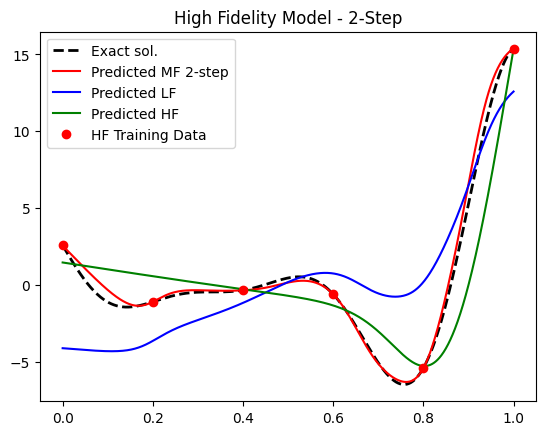

In [9]:
# Plot results
plt.figure()
plt.plot(x_test, Yhf_test, '--k', label='Exact sol.', linewidth = 2)
plt.plot(x_test, yMF, 'r-', label='Predicted MF 2-step')
plt.plot(x_test, yLF, 'b-', label = 'Predicted LF')
plt.plot(x_test, yHF, 'g-', label = 'Predicted HF')
plt.plot(xhf, Yhf, 'ro', label='HF Training Data')

plt.legend()
plt.title('High Fidelity Model - 2-Step')
plt.show()

In [10]:
# Print percentage errors for LF, HF and MF
print('LF error: ', np.linalg.norm(yLF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('HF error: ', np.linalg.norm(yHF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('MF error: ', np.linalg.norm(yMF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')

LF error:  69.6451327269948 %
HF error:  47.04855598163648 %
MF error:  11.129436994441475 %


⭐ Leave a star to the github repo if you enojyed :)